# librarie

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

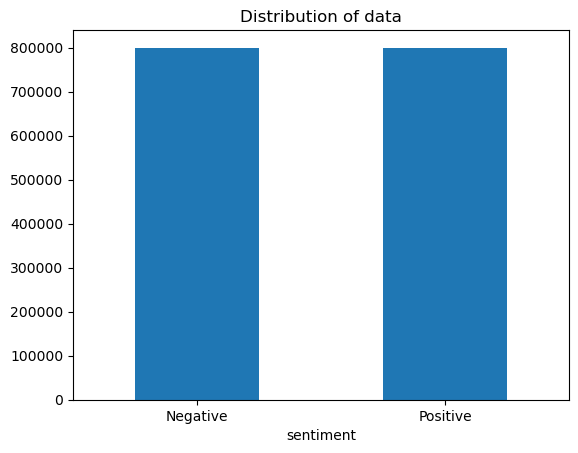

In [2]:
# Importing the dataset
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('dataset/sentiment140.csv',
                      encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment', 'text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [3]:
dataset.describe

<bound method NDFrame.describe of          sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]>

# preprocess

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked', ':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before',
                'being', 'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do',
                'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
                'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                'into', 'is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                'me', 'more', 'most', 'my', 'myself', 'now', 'o', 'of', 'on', 'once',
                'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'own', 're',
                's', 'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such',
                't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
                'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
                'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
                'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre",
                "youve", 'your', 'yours', 'yourself', 'yourselves']

In [5]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern, ' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            # if word not in stopwordlist:
            if len(word) > 1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xuenichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 47 seconds


# analyze

## Word-Cloud for Negative

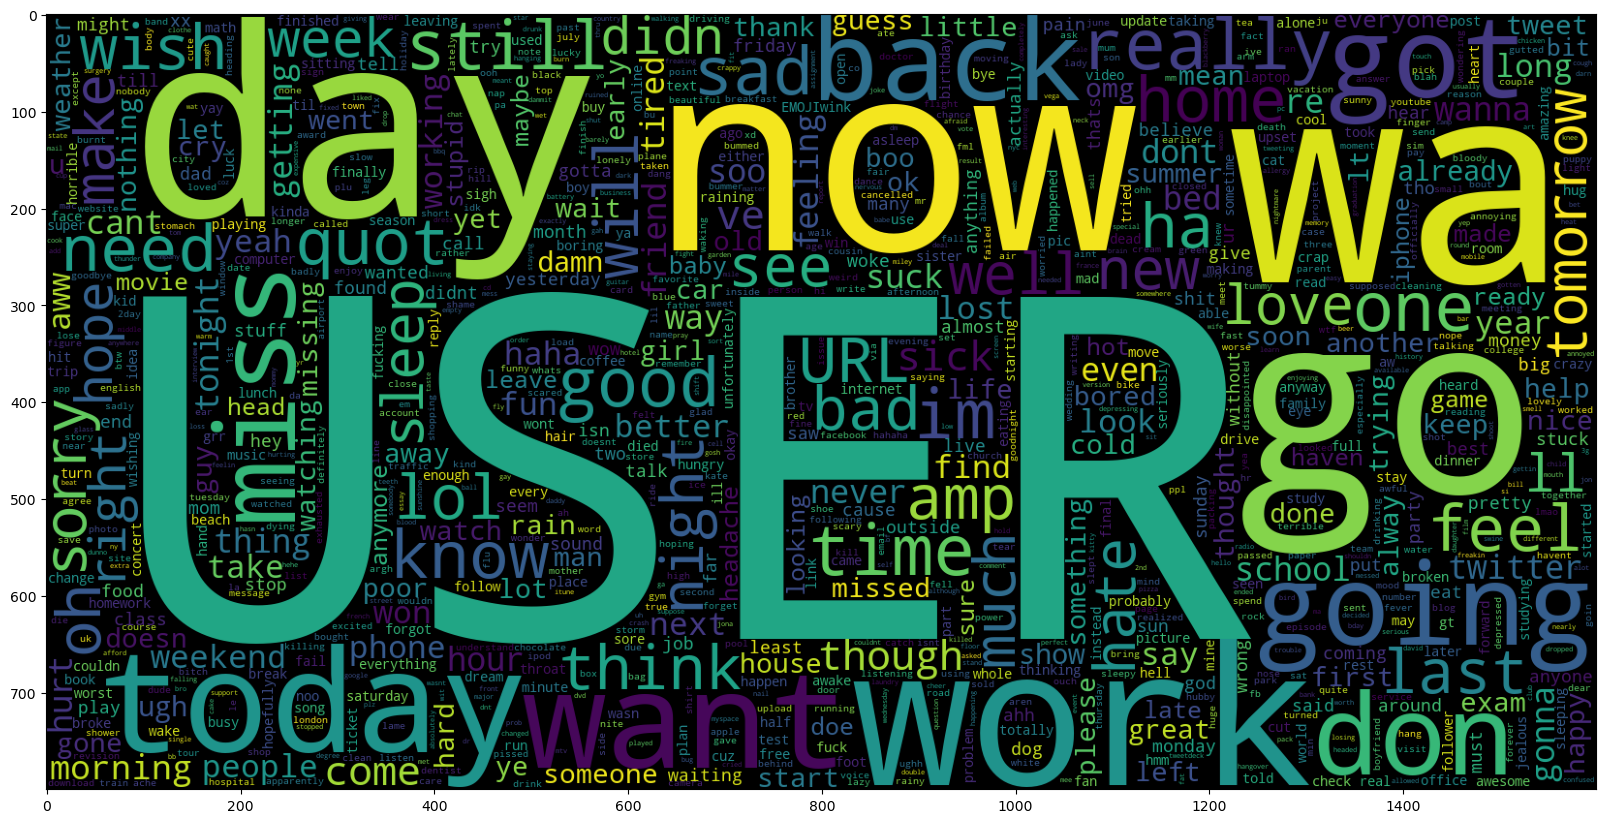

In [8]:
data_neg = processedtext[:800000]
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## Word-Cloud for Positive

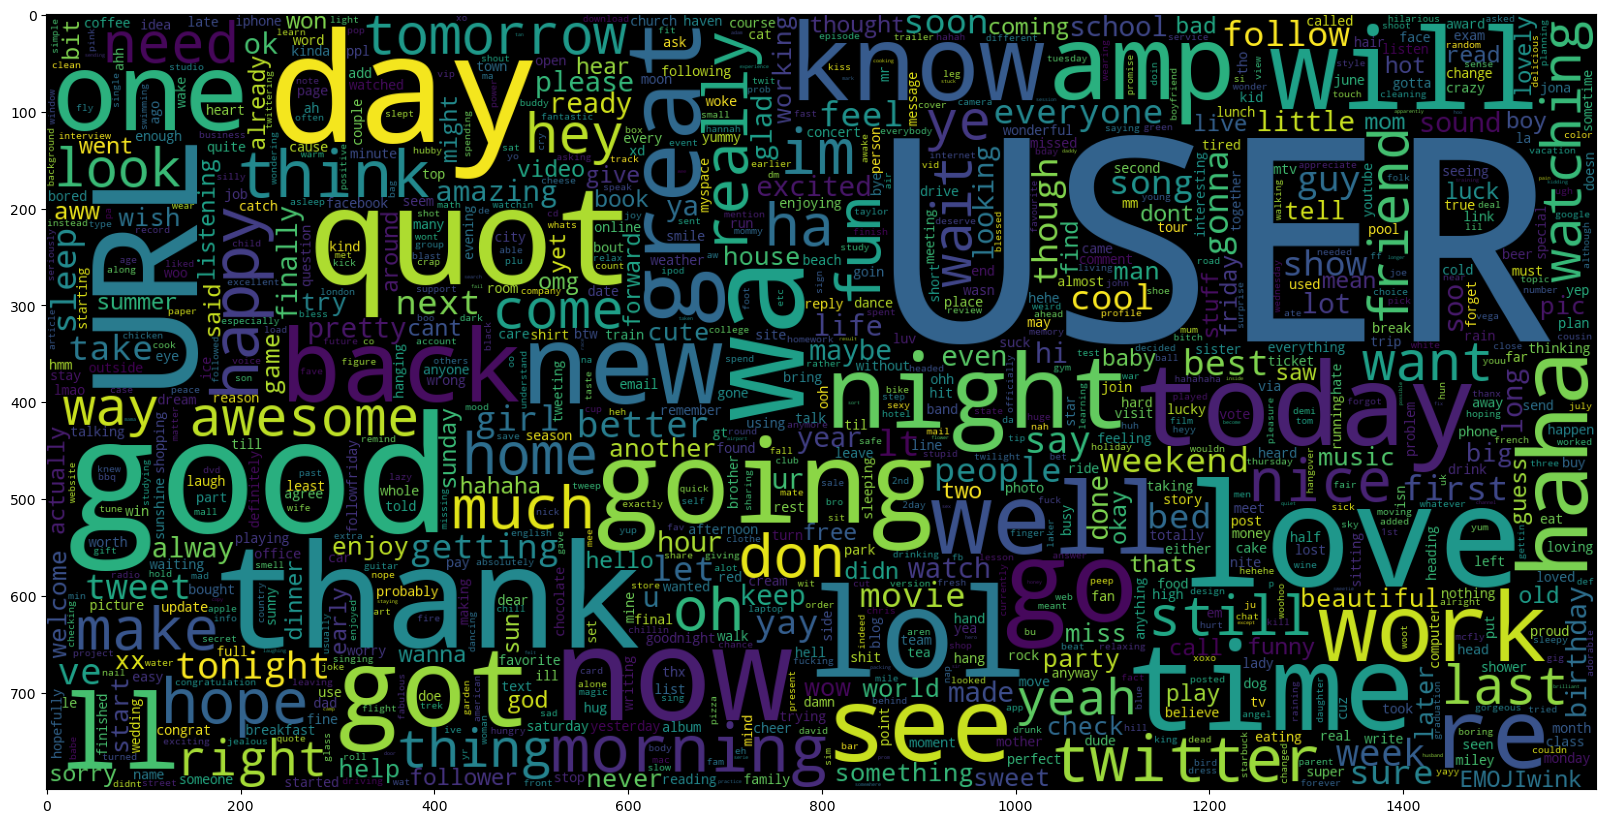

In [9]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(20, 20))
plt.imshow(wc)

## Training

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size=0.05, random_state=0)
print(f'Data Split done.')

Data Split done.


In [11]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


In [12]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Evaluation

In [13]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

## BernoulliNB Model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



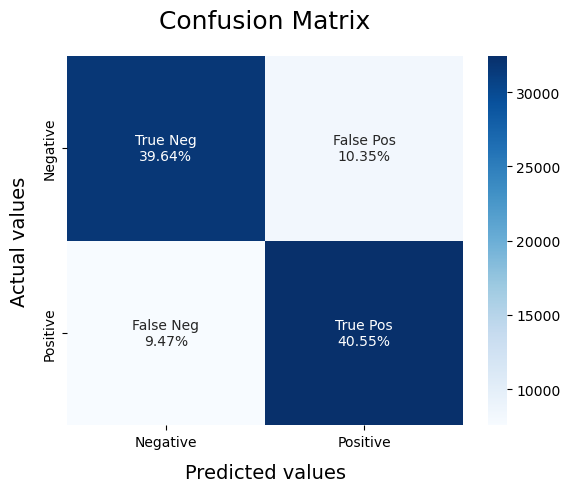

In [14]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

## LinearSVC

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



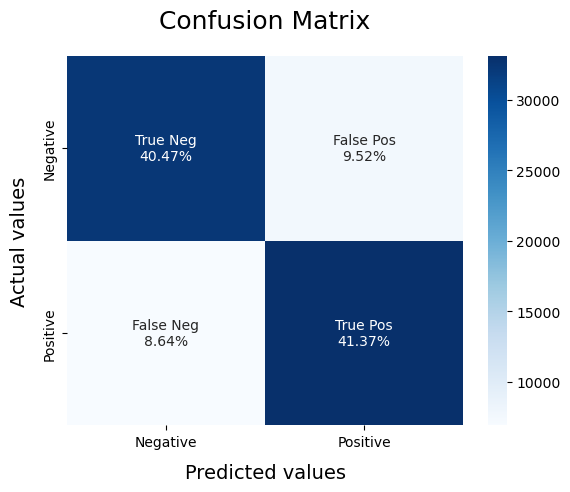

In [15]:
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



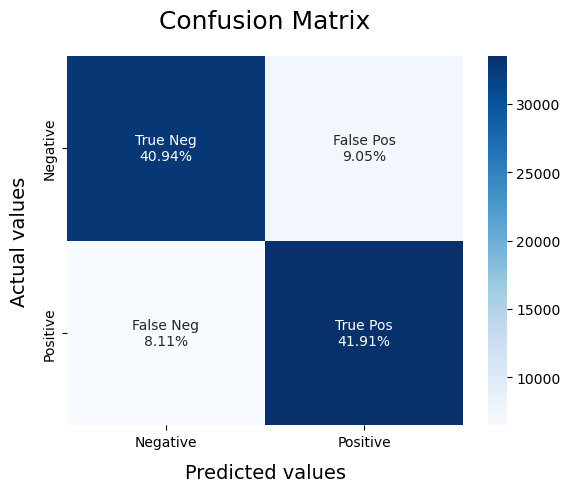

In [16]:
LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)